In [51]:
from typing import List
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import BertModel, BertTokenizer
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

# Preprocessing functions
def delete_sign_from_column(dataframe, column_name, sign_to_remove):
    dataframe[column_name] = dataframe[column_name].str.replace(sign_to_remove, "")
    return dataframe


def split_to_list(dataframe, column_name):
    dataframe[column_name] = dataframe[column_name].str.split(', ')
    return dataframe


# Embedding functions
def get_embeddings_for_cell(cell: List[str]):
    if cell is ['']:
        return None
    mean_embeddings = np.mean([get_embeddings(term) for term in cell], axis=0)
    return mean_embeddings


def write_embeddings_for_all_columns(dataframe, column_name):
    dataframe[f"{column_name} Embedding"] = dataframe[column_name].progress_apply(lambda x: get_embeddings_for_cell(x))
    return dataframe

def get_embeddings(term: str):
    if term is ['']:
        return None
    keywords = term.split(' ')
    # Get the mean of embeddings for each keyword
    embedding = np.mean([model.encode(keyword) for keyword in keywords], axis=0)
    return embedding


def get_averaged_embeddings(terms):
    if not terms:
        return None
    # Join the terms into a single string
    text = ' '.join(terms)
    # Get the embeddings for the combined string
    embedding = model.encode(text)
    averaged_embedding = np.mean(embedding, axis=0)
    return averaged_embedding

In [52]:
# Load a pre-trained sentence transformer model
model_name = 'bert-base-nli-mean-tokens'  # You can choose a different model
bio_model = "dmis-lab/biobert-v1.1"
model = SentenceTransformer(bio_model)

No sentence-transformers model found with name C:\Users\InbarBlech/.cache\torch\sentence_transformers\dmis-lab_biobert-v1.1. Creating a new one with MEAN pooling.


In [30]:
### Loading and preprocessing ###
# Load your CSV file
input_csv_file_path = 'C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\hl_genes_with_go_terms_lists.csv'
df = pd.read_csv(input_csv_file_path)

# remove all signs from the go terms, and split to lists
for column in ['Cellular Component', 'Biological Process', 'Molecular Function']:
    for sign in ["'", "[", "]"]:
        df = delete_sign_from_column(df, column, sign)
    df = split_to_list(df, column)

In [31]:
### Embedding ###
# Apply the embeddings to each row in the DataFrame
for column in ['Cellular Component']:
    df = write_embeddings_for_all_columns(df, column)

# Save the DataFrame to a CSV file
csv_file_path = f'C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\go terms\\hl_genes_with_go_terms_mean_embeddings_biobert_29.1.csv'
df.to_csv(csv_file_path, index=False)

  0%|          | 0/212 [00:00<?, ?it/s]

In [32]:
# Get 5 clusters from the "mulicolar function" column in df using K-means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Get the embeddings for the "Molecular Function" column
X = df['Cellular Component Embedding'].to_numpy()
# Remove the None values
X = [x for x in X if x is not None]
# Convert the list to a numpy array
X = np.array(X)
# Get the number of clusters
k = 6
# Run K-means
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
# Get the labels
labels = kmeans.labels_
# Get the silhouette score
print(f"silhouette score: {silhouette_score(X, labels, metric='euclidean')}")
clusters: pd.DataFrame = pd.DataFrame(labels, columns=['cluster'])
# Add the clusters to the DataFrame
df['cluster'] = clusters['cluster']

silhouette score: 0.18361303210258484


In [33]:
# sort df by cluster
df = df.sort_values(by=['cluster'])
to_display_df = df.drop(['Cellular Component Embedding', 'Molecular Function', 'Biological Process'], axis=1)
df.to_csv('C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\go terms\\hl_genes_clusters_biobert_29.1.csv', index=False)

In [36]:
# keep only collagen genes
collagen_genes_df = to_display_df[to_display_df['Gene'].str.contains('SLC')]

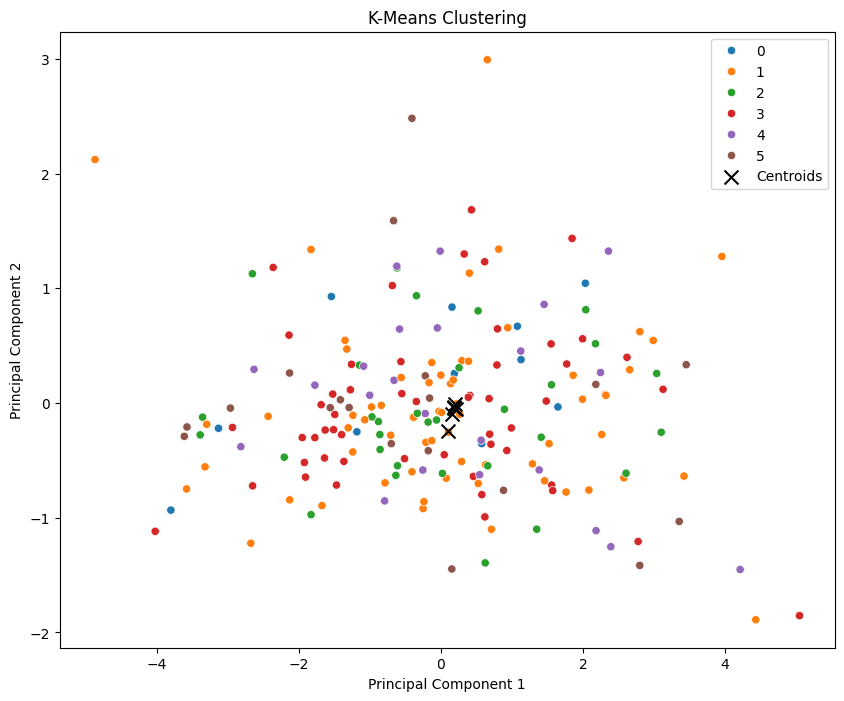

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

cluster_centers = kmeans.cluster_centers_

# Assuming X is your original data
X = df['Cellular Component Embedding'].to_numpy()
X = np.array([x for x in X if x is not None])  # Remove None values and convert to numpy array

# Perform PCA
pca = PCA(n_components=2)  # Specify the number of components you want
X_pca = pca.fit_transform(X)

# X_pca now contains the PCA-transformed data

# Plot the original data points
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='tab10', legend='full')

# Plot the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='x', s=100, label='Centroids')

# Add labels and legend
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [49]:
df

,Gene,Cellular Component,Biological Process,Molecular Function,Cellular Component Embedding,cluster
169,TMEM126A,"[mitochondrial inner membrane, mitochondrion, ...",[mitochondrial respiratory chain complex I ass...,[],"[0.17557247, -0.06433857, -0.06778697, -0.1441...",0
119,BCS1L,"[mitochondrial inner membrane, mitochondrial r...","[mitochondrial cytochrome c oxidase assembly, ...","[ATP binding, ATP hydrolysis activity]","[0.26079187, -0.07365874, -0.034578506, -0.271...",0
125,TIMM8A,"[mitochondrial inner membrane, mitochondrial i...","[nervous system development, protein insertion...","[identical protein binding, metal ion binding]","[0.21609819, -0.05343076, -0.019446533, -0.195...",0
177,KARS1,[aminoacyl-tRNA synthetase multienzyme complex...,[basophil activation involved in immune respon...,"[amino acid binding, ATP adenylyltransferase a...","[0.17405592, -0.06768815, -0.09903644, -0.2225...",0
28,TWNK,"[mitochondrial matrix, mitochondrial nucleoid,...","[cellular response to glucose stimulus, DNA un...","[""5-3 DNA helicase activity"", ATP binding, ATP...","[0.16376996, -0.07287636, -0.05786175, -0.2640...",0
...,...,...,...,...,...,...
74,TBL1X,"[histone deacetylase complex, mitotic spindle,...",[negative regulation of transcription by RNA p...,"[histone binding, identical protein binding, t...","[0.10358725, -0.19658403, -0.16275308, -0.1463...",5
75,TRRAP,"[Golgi apparatus, NuA4 histone acetyltransfera...","[chromatin organization, DNA repair, positive ...",[transcription coregulator activity],"[0.130643, -0.21785434, -0.14397427, -0.149438...",5
77,KMT2D,"[MLL3/4 complex, nucleoplasm, nucleus]","[beta-catenin-TCF complex assembly, heterochro...","[DNA binding, histone binding, histone H3K4 me...","[0.0540788, -0.20108354, -0.21547906, -0.16616...",5
136,PAX1,"[chromatin, nucleus]","[anatomical structure development, regulation ...","[DNA-binding transcription factor activity, RN...","[0.1000257, -0.32473165, -0.119428456, -0.1731...",5
